# Implementation of Zonal Integration
after: 2D zonal integration with unordered data, Greg A. Smith https://doi.org/10.1364/AO.426162

$ Z = D^+ \cdot G$

$ D^+ = (D^T D)^{-^1}D^T $

Z = desired shape
G = Gradient data
D = transformation Matrix

Indexing:

$[x_k, y_k]$ = index of gradient data

$[X_n, Y_n]$ = index of surface shape 

Defenition:

$\Delta X_n = X_n - x_k$

$\Delta Y_n = Y_n -y_k$

Matrix repesentation of Tylor expension of correction coeffication $c_n$

<div>
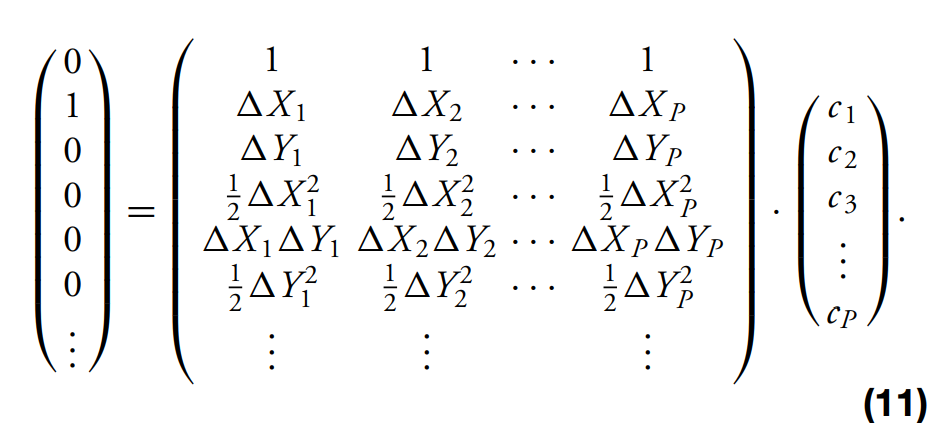
</div>

$V = M \cdot C$

A valid solution only requires the number of Taylor terms must be less than or equal to the number of nearby points

$C = M^+ \cdot V$

$M^+ = (M^T M)^{-1} M^T$

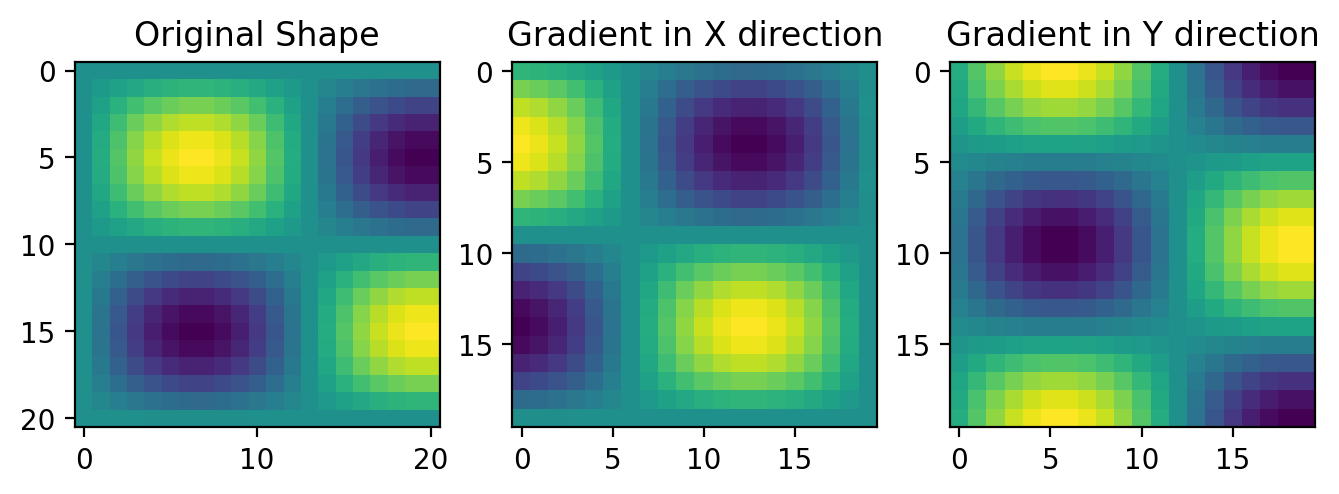

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds 
from scipy.linalg.interpolative import svd as isvd
from numpy.linalg import svd 
#from numba import njit, prange


# set random seed to scramble the gradient locatoins
np.random.seed(0)

# define example data 
k = 20 # nuber gradient points'
xk_amp = np.linspace(0,2*np.pi,k+1) #+ np.random.rand(k+1) /4
yk_amp = np.linspace(0,2*np.pi,k+1) #+ np.random.rand(k+1) /4


# slice pos for gradint
xk_array = xk_amp[0:-1] + (xk_amp[1::] - xk_amp[0:-1])/2
yk_array = yk_amp[0:-1] + (yk_amp[1::] - yk_amp[0:-1])/2

G2x, G2y = np.meshgrid(xk_amp,yk_amp)

Gy_fun = lambda x: np.sin(x) #+ (x**2)/50
G_amp = Gy_fun(G2x/1.3) *  Gy_fun(G2y)


G_grad_x = np.diff(G_amp,axis=1)[1::,:]
G_grad_y = np.diff(G_amp,axis=0)[:,1::]

fig, ax = plt.subplots(1,3,figsize=(8,8),dpi=200)
ax[0].imshow(G_amp)
ax[0].set_title("Original Shape")

ax[1].imshow(G_grad_x)
ax[1].set_title("Gradient in X direction")

ax[2].imshow(G_grad_y)
ax[2].set_title("Gradient in Y direction")
plt.show()


In [18]:
def make1D(A):
    return np.reshape(A, A.shape[0] * A.shape[1])


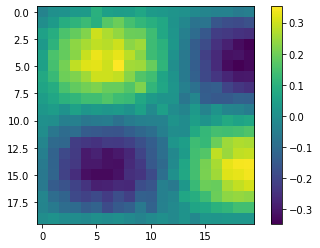

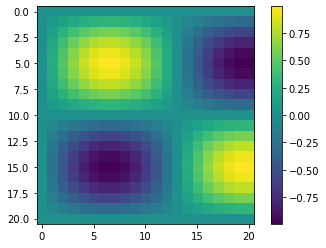

CPU times: user 6.82 s, sys: 70.2 ms, total: 6.89 s
Wall time: 5.81 s


In [32]:
%%time
# xk yk : gradient position
# G : gradient Manitude

pinv = np.linalg.pinv

#pinv = linalg.pinv
# number of neighbouring points
P = 15

#1 construct vector Gvia Eq. (2)
G = np.concatenate([make1D(G_grad_x),make1D(G_grad_y)]) # append dy to dx like eqasion 2

#2 choose desired shape data locations [Xn,Yn]

n_res = 20
Xn_array = np.linspace(xk_array[0],xk_array[-1],n_res)
Yn_array = np.linspace(yk_array[0],yk_array[-1],n_res) 

Xn_2D, Yn_2D =  np.meshgrid(Xn_array,Yn_array)
Xn, Yn = make1D(Xn_2D), make1D(Yn_2D)

xk_array_1d, yk_array_1d =  np.meshgrid(xk_array,yk_array)
xk_array_1d, yk_array_1d = make1D(xk_array_1d), make1D(yk_array_1d)

# index where the Y array starts 
K = len(xk_array_1d)

# 
C = np.zeros((2*K, len(Xn) ))
#C = np.empty((2*K, len(Xn)))
#C[:,:] = np.NaN


#loop over all koordinates [1:100]
for i, (xk ,yk) in enumerate(zip(xk_array_1d, yk_array_1d)):
    # C = np.zeros((2*K, len(Xn)))
    # calculate distance to dots
    dX =  xk - Xn
    dY =  yk - Yn
    
    distance = np.sqrt(np.square(dX) + np.square(dY))
    distance_idx = np.argsort(distance)
    
    #plt.plot(xk,yk,"o")
    #plt.plot(Xn,Yn,"x")
    #plt.plot(Xn[distance_idx[0:P]],Yn[distance_idx[0:P]],"rx")

    # get closest P points 
    # dX = dX[distance_idx[0:P]]
    # dY = dY[distance_idx[0:P]]

    dX = Xn[distance_idx[0:P]] - xk
    dY = Yn[distance_idx[0:P]] - yk

    # --- X Components ---
    # taylor series Matrix
    M = np.array([np.ones(len(dX)), 
                  dX,
                  dY,#])
                  (dX**2)/2, 
                  dX*dY,
                  (dX**2)/2])

    # "Zero" Array with the number of Taylor polinom
    V = np.zeros((np.size(M,0),1))
    V[1] = 1
    
    M_pinv = pinv(M)
    
    C[i,distance_idx[0:P]] = (M_pinv @ V).T
    

    # # --- Y Components ---
    # # taylor series Matrix
    # M = np.array([np.ones(len(dX)), 
    #               dX,
    #               dY,
    #               (dX**2)/2, 
    #               dX*dY,
    #               (dX**2)/2])

    # "Zero" Array with the number of Taylor polinom
    V = np.zeros((np.size(M,0),1))
    V[2] = 1
    C[i+K,distance_idx[0:P]] = (M_pinv @ V).T
     
    
    # D = np.append(C, np.zeros((C.shape[0],1)), axis=1)
    # Z = pinv(D) @ G
    # Z_shape = np.reshape(Z[0:-1],(n_res,n_res))
    # plt.imshow(Z_shape, vmin=-1, vmax=1)
    # plt.show()
    # #plt.plot(xk,yk,".")
empty_row = np.zeros((C.shape[0],1))
empty_row[2] = 1
D = np.append(C, empty_row, axis=1)
D = C
Z2 = np.linalg.lstsq(D,G,rcond=None)[0]
Z2_shape = np.reshape(Z2,(n_res,n_res))

a = plt.imshow(Z2_shape); plt.colorbar(a)
plt.show()
a = plt.imshow(G_amp); plt.colorbar(a)
plt.show()


In [6]:
# Sparceity of matix D
np.size(D[D == 0]) / np.size(D) 

0.987249149659864

In [7]:
%%time
Z = np.linalg.pinv(D) @ G

CPU times: user 54.6 s, sys: 455 ms, total: 55 s
Wall time: 55.5 s


In [8]:
d32 = np.float32(D) 
g32 = np.float32(G)

In [9]:
%%time
Z1 = np.linalg.pinv(d32) @ g32

CPU times: user 47.5 s, sys: 309 ms, total: 47.8 s
Wall time: 47.9 s


In [27]:
%%time
Z2 = np.linalg.lstsq(D,G,rcond=None)[0]

CPU times: user 8.95 s, sys: 19.6 ms, total: 8.97 s
Wall time: 8.97 s


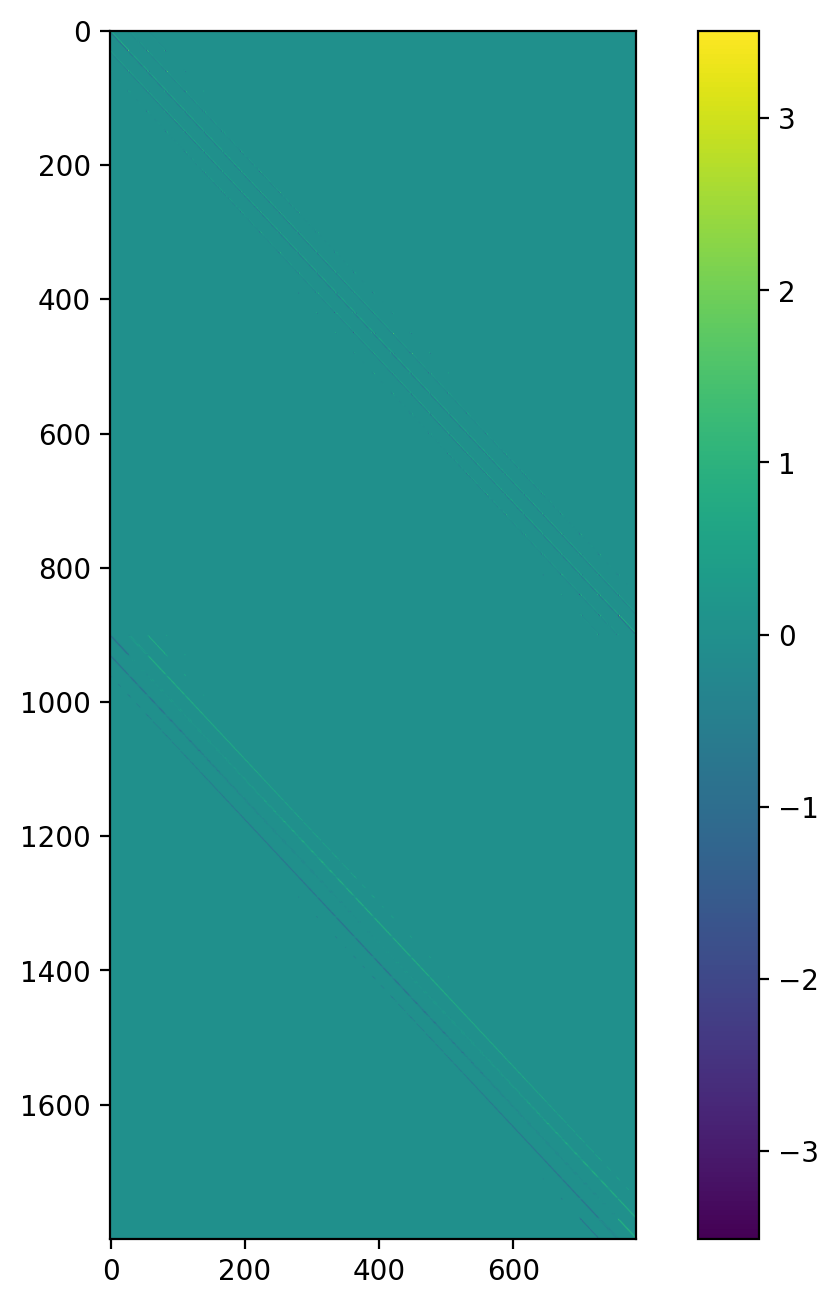

In [11]:
fig, ax = plt.subplots(figsize=(8,8),dpi=200)
c = plt.imshow(D); plt.colorbar(c)

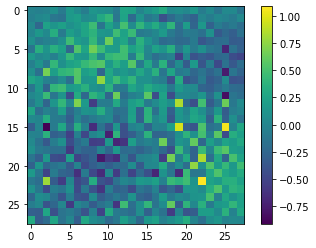

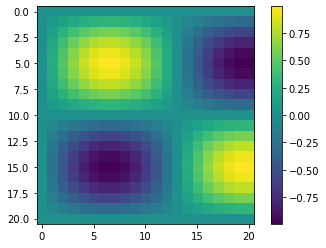

In [28]:
Z2 = np.linalg.lstsq(D,G,rcond=None)[0]
Z2_shape = np.reshape(Z2,(n_res,n_res))

a = plt.imshow(Z2_shape); plt.colorbar(a)
plt.show()
a = plt.imshow(G_amp); plt.colorbar(a)
plt.show()


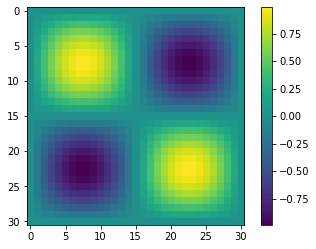

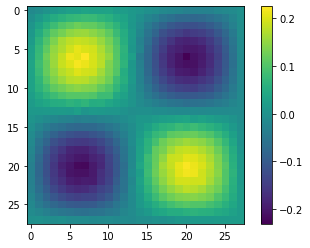

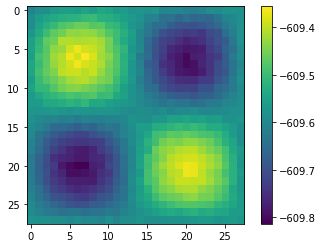

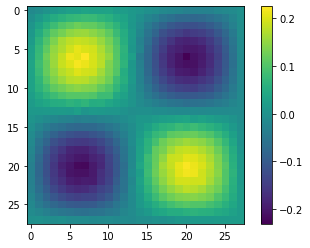

In [12]:

#fig, ax = plt.subplots(1,3,figsize=(5,5),dpi=200)

#Z_shape = np.reshape(Z[0:-1],(n_res,n_res))
Z_shape = np.reshape(Z,(n_res,n_res))
Z1_shape = np.reshape(Z1,(n_res,n_res))
Z2_shape = np.reshape(Z2,(n_res,n_res))

a= plt.imshow(G_amp); plt.colorbar(a)
plt.show()
a = plt.imshow(Z_shape); plt.colorbar(a)
plt.show()
a = plt.imshow(Z1_shape); plt.colorbar(a)
plt.show()
a = plt.imshow(Z2_shape); plt.colorbar(a)
plt.show()
#a = plt.imshow(Z_shape-G_amp[1::,1::]); plt.colorbar(a)


# first test fith the matrix operations

In [61]:
# Sample points with the number of Parner
dX = np.linspace(0,10,5)
dY = np.linspace(0,10,5)

# taylor series Matrix
M = np.array([np.ones(len(dX)), 
              dX,
              dY,
              (dX**2)/2, 
              dX*dY,
              (dX**2)/2])

# "Zero" Array with the number of Taylor polinom
V = np.zeros((np.size(M,0),1))
V[1] = 1
print(V)

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [62]:
C = np.linalg.pinv(M) @ V

# Implementation of Zonal Integration
after: 2D zonal integration with unordered data, Greg A. Smith https://doi.org/10.1364/AO.426162

$ Z = D^+ \cdot G$

$ D^+ = (D^T D)^{-^1}D^T $

Z = desired shape
G = Gradient data
D = transformation Matrix

Indexing:

$[x_k, y_k]$ = index of gradient data

$[X_n, Y_n]$ = index of surface shape 

Defenition:

$\Delta X_n = X_n - x_k$

$\Delta Y_n = Y_n -y_k$

Matrix repesentation of Tylor expension of correction coeffication $c_n$

<div>
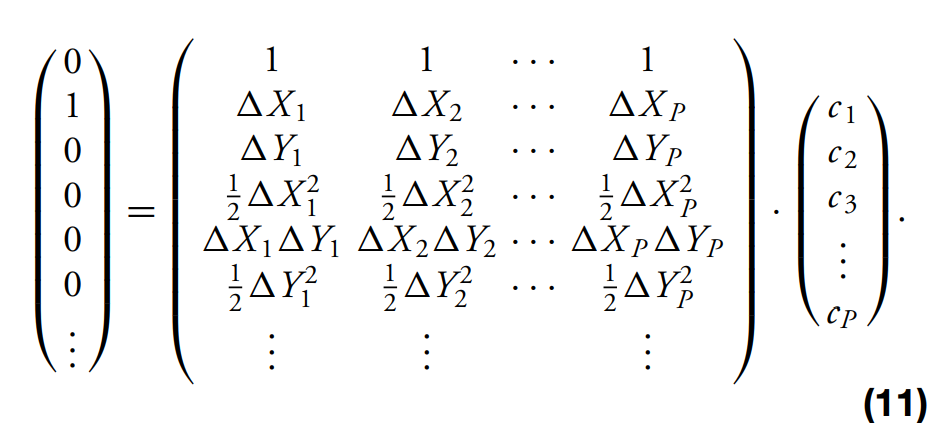
</div>

$V = M \cdot C$

A valid solution only requires the number of Taylor terms must be less than or equal to the number of nearby points

$C = M^+ \cdot V$

$M^+ = (M^T M)^{-1} M^T$

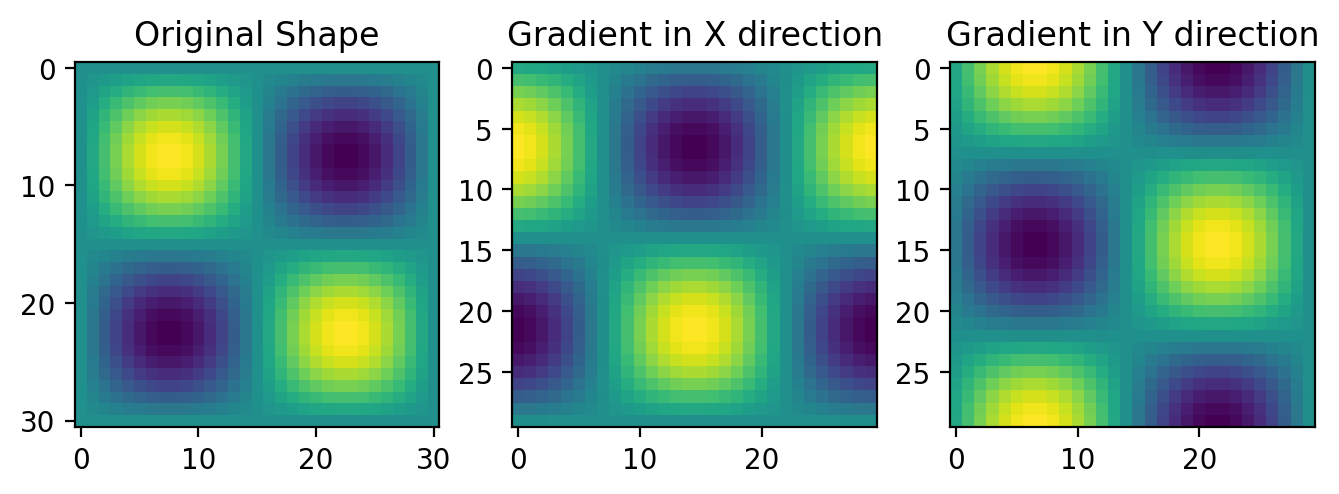

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds 
from scipy.linalg.interpolative import svd as isvd
from numpy.linalg import svd 
from numba import njit, prange


# set random seed to scramble the gradient locatoins
np.random.seed(0)

# define example data 
k = 30 # nuber gradient points'
xk_amp = np.linspace(0,2*np.pi,k+1) #+ np.random.rand(k+1) /4
yk_amp = np.linspace(0,2*np.pi,k+1) #+ np.random.rand(k+1) /4


# slice pos for gradint
xk_array = xk_amp[0:-1] + (xk_amp[1::] - xk_amp[0:-1])/2
yk_array = yk_amp[0:-1] + (yk_amp[1::] - yk_amp[0:-1])/2

G2x, G2y = np.meshgrid(xk_amp,yk_amp)

Gy_fun = lambda x: np.sin(x) #+ (x**2)/50
G_amp = Gy_fun(G2x) *  Gy_fun(G2y)


G_grad_x = np.diff(G_amp,axis=1)[1::,:]
G_grad_y = np.diff(G_amp,axis=0)[:,1::]

fig, ax = plt.subplots(1,3,figsize=(8,8),dpi=200)
ax[0].imshow(G_amp)
ax[0].set_title("Original Shape")

ax[1].imshow(G_grad_x)
ax[1].set_title("Gradient in X direction")

ax[2].imshow(G_grad_y)
ax[2].set_title("Gradient in Y direction")
plt.show()


In [75]:
def make1D(A):
    return np.reshape(A, A.shape[0] * A.shape[1])


In [76]:
%%time
# xk yk : gradient position
# G : gradient Manitude

pinv = np.linalg.pinv

#pinv = linalg.pinv
# number of neighbouring points
P = 10

#1 construct vector Gvia Eq. (2)
G = np.concatenate([make1D(G_grad_x),make1D(G_grad_y)]) # append dy to dx like eqasion 2

#2 choose desired shape data locations [Xn,Yn]

n_res = 28
Xn_array = np.linspace(xk_array[0],xk_array[-1],n_res)
Yn_array = np.linspace(yk_array[0],yk_array[-1],n_res) 

Xn_2D, Yn_2D =  np.meshgrid(Xn_array,Yn_array)
Xn, Yn = make1D(Xn_2D), make1D(Yn_2D)

xk_array_1d, yk_array_1d =  np.meshgrid(xk_array,yk_array)
xk_array_1d, yk_array_1d = make1D(xk_array_1d), make1D(yk_array_1d)

# index where the Y array starts 
K = len(xk_array_1d)

# 
C = np.zeros((2*K, len(Xn) ))
#C = np.empty((2*K, len(Xn)))
#C[:,:] = np.NaN


#loop over all koordinates [1:100]
for i, (xk ,yk) in enumerate(zip(xk_array_1d, yk_array_1d)):
    # C = np.zeros((2*K, len(Xn)))
    # calculate distance to dots
    dX =  xk - Xn
    dY =  yk - Yn
    
    distance = np.sqrt(np.square(dX) + np.square(dY))
    distance_idx = np.argsort(distance)
    
    #plt.plot(xk,yk,"o")
    #plt.plot(Xn,Yn,"x")
    #plt.plot(Xn[distance_idx[0:P]],Yn[distance_idx[0:P]],"rx")

    # get closest P points 
    # dX = dX[distance_idx[0:P]]
    # dY = dY[distance_idx[0:P]]

    dX = Xn[distance_idx[0:P]] - xk
    dY = Yn[distance_idx[0:P]] - yk

    # --- X Components ---
    # taylor series Matrix
    M = np.array([np.ones(len(dX)), 
                  dX,
                  dY,#])
                  (dX**2)/2, 
                  dX*dY,
                  (dX**2)/2])

    # "Zero" Array with the number of Taylor polinom
    V = np.zeros((np.size(M,0),1))
    V[1] = 1
    
    M_pinv = pinv(M)
    
    C[i,distance_idx[0:P]] = (M_pinv @ V).T
    

    # # --- Y Components ---
    # # taylor series Matrix
    # M = np.array([np.ones(len(dX)), 
    #               dX,
    #               dY,
    #               (dX**2)/2, 
    #               dX*dY,
    #               (dX**2)/2])

    # "Zero" Array with the number of Taylor polinom
    V = np.zeros((np.size(M,0),1))
    V[2] = 1
    C[i+K,distance_idx[0:P]] = (M_pinv @ V).T
     
    
    # D = np.append(C, np.zeros((C.shape[0],1)), axis=1)
    # Z = pinv(D) @ G
    # Z_shape = np.reshape(Z[0:-1],(n_res,n_res))
    # plt.imshow(Z_shape, vmin=-1, vmax=1)
    # plt.show()
    # #plt.plot(xk,yk,".")
empty_row = np.zeros((C.shape[0],1))
empty_row[2] = 1
D = np.append(C, empty_row, axis=1)
D = C


Wall time: 263 ms


In [77]:
# Sparceity of matix D
np.size(D[D == 0]) / np.size(D) 

0.9872470238095238

In [78]:
%%time
Z = np.linalg.pinv(D) @ G

Wall time: 443 ms


In [79]:
d32 = np.float32(D) 
g32 = np.float32(G)

In [80]:
%%time
Z1 = np.linalg.pinv(d32) @ g32

Wall time: 451 ms


In [81]:
%%time
Z2 = np.linalg.lstsq(D,G,rcond=None)[0]

Wall time: 207 ms


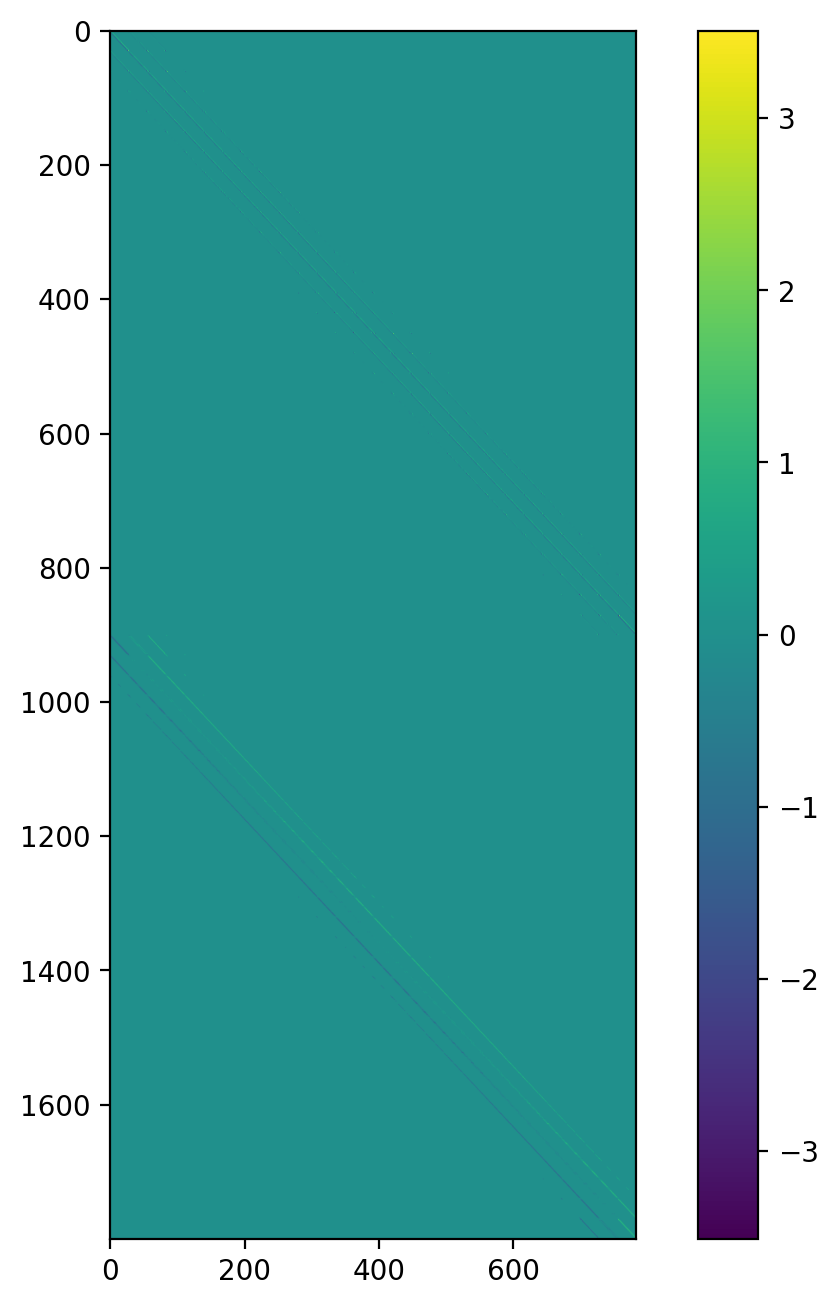

In [82]:
fig, ax = plt.subplots(figsize=(8,8),dpi=200)
c = plt.imshow(D); plt.colorbar(c)

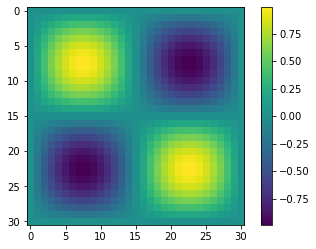

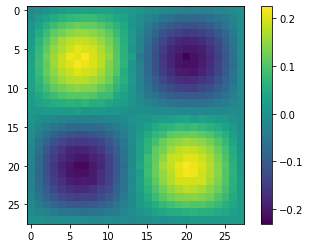

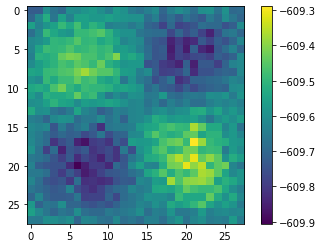

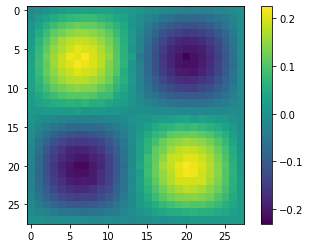

In [84]:

#fig, ax = plt.subplots(1,3,figsize=(5,5),dpi=200)

#Z_shape = np.reshape(Z[0:-1],(n_res,n_res))
Z_shape = np.reshape(Z,(n_res,n_res))
Z1_shape = np.reshape(Z1,(n_res,n_res))
Z2_shape = np.reshape(Z2,(n_res,n_res))

a= plt.imshow(G_amp); plt.colorbar(a)
plt.show()
a = plt.imshow(Z_shape); plt.colorbar(a)
plt.show()
a = plt.imshow(Z1_shape); plt.colorbar(a)
plt.show()
a = plt.imshow(Z2_shape); plt.colorbar(a)
plt.show()
#a = plt.imshow(Z_shape-G_amp[1::,1::]); plt.colorbar(a)


# first test fith the matrix operations

In [61]:
# Sample points with the number of Parner
dX = np.linspace(0,10,5)
dY = np.linspace(0,10,5)

# taylor series Matrix
M = np.array([np.ones(len(dX)), 
              dX,
              dY,
              (dX**2)/2, 
              dX*dY,
              (dX**2)/2])

# "Zero" Array with the number of Taylor polinom
V = np.zeros((np.size(M,0),1))
V[1] = 1
print(V)

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [62]:
C = np.linalg.pinv(M) @ V